# Digit Identification: PyTorch vs. TensorFlow

The purpose of this notebook is to compare deep learning models built by PyTorch and TensorFlow for identifying handwritten digits. 

The  collection used in this notebook is found in [Kaggle](https://www.kaggle.com/datasets/jcprogjava/handwritten-digits-dataset-not-in-mnist) and is not from the MINST dataset. There are 10773 images of each of the ten digits in PNG format. In the following, I will, first, make a DataFrame of the images' pixel data and build neural network models using PyTorch and TensorFlow. 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import torch
from torch import nn

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import warnings
warnings.filterwarnings(action='ignore')

## Build Image Dataset

(28, 28, 4)

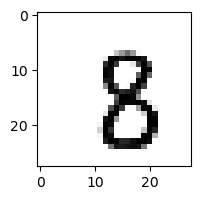

In [62]:
# getting image dimensions

img = Image.open('8/8/110.png')
plt.figure(figsize=(2,2))
plt.imshow(img)
img_arr = np.asarray(img)
img_arr.shape

Now that we know the dimensions of the images, `28 * 28 * 4`, we can make a function to convert each image folder into a DataFrame.

In [3]:
# A function to convert image data to pandas DataFrame

def image_to_dataframe(path, img_count, img_label):
    '''
    path (str): the file path of images
    img_count (int): the number of images in the path folder
    img_label (int): the digit that images represent
    '''
    
    df = pd.DataFrame(columns = [i for i in range(3136)]) # 24 * 24 * 4 = 3136
    for i in range(img_count):
        img = np.asarray(Image.open(path+str(i)+'.png'))
        df.loc[len(df)] = img.reshape(-1)

    df['digit'] = img_label
    return df

In [4]:
# Dataframe of ten digits images
time_start = time.time()

df_0 = image_to_dataframe('0/0/', 10772, 0)
df_1 = image_to_dataframe('1/1/', 10772, 1)
df_2 = image_to_dataframe('2/2/', 10772, 2)
df_3 = image_to_dataframe('3/3/', 10772, 3)
df_4 = image_to_dataframe('4/4/', 10772, 4)
df_5 = image_to_dataframe('5/5/', 10772, 5)
df_6 = image_to_dataframe('6/6/', 10772, 6)
df_7 = image_to_dataframe('7/7/', 10772, 7)
df_8 = image_to_dataframe('8/8/', 10772, 8)
df_9 = image_to_dataframe('9/9/', 10772, 9)

print('Time Elapsed: {} seconds'.format(time.time() - time_start))

Time Elapsed: 322.1026051044464 seconds


In [5]:
df_all = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9],
                     ignore_index = True)

#shuffle the dataframe
df_digits = df_all.sample(frac=1).reset_index(drop=True)

In [6]:
df_digits

,0,1,2,3,4,5,6,7,8,9,...,3127,3128,3129,3130,3131,3132,3133,3134,3135,digit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107715,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
107716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
107717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
107718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


Now we have a dataset of all image pixel data and it is better to save the whole in a `.csv` file for later applications.

In [7]:
df_digits.to_csv('Digits.csv')

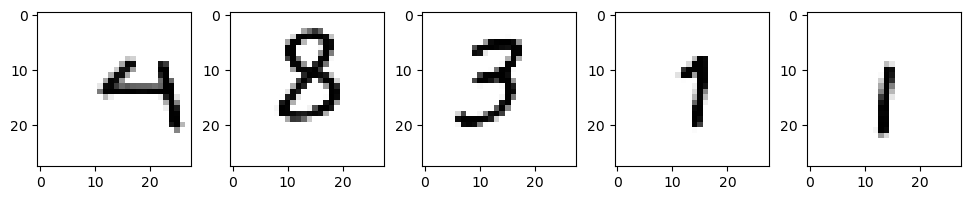

In [55]:
# visualizing sample images
plt.figure(figsize=(12,2))

for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(df_digits.iloc[120+i,:3136].values.reshape(28,28,4))

plt.show()

## Split data into train and test sets

Rows in `df_digits` dataframe are numpy arrays, but for the PyTorch model, we must convert them into tensors before splitting into train and test sets.

In [9]:
# Spliitng data into train and test sets

# set the hyperparameters for data creation
NUM_CLASSES = 10
RANDOM_SEED = 42

X = df_digits.drop('digit', axis=1)
y = df_digits['digit']


# 2. Converting data into tensors
X = torch.tensor(X.to_numpy()).type(torch.float)
y = torch.from_numpy(y.to_numpy()).type(torch.LongTensor) # Must be LongTensor --> see documentation


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = RANDOM_SEED)

X.shape, y.shape, X_train.shape, y_train.shape

(torch.Size([107720, 3136]),
 torch.Size([107720]),
 torch.Size([86176, 3136]),
 torch.Size([86176]))

---

## PyTorch Model

In [10]:
class DigitIdentification(nn.Module):
    def __init__(self, input_features, output_features, hidden_sizes = [784, 128, 64]):
        super().__init__()
        self.linear_layers = nn.Sequential(
            nn.Linear(input_features, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[2], output_features),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.linear_layers(x)

model_1 = DigitIdentification(input_features = X.shape[1],
                              output_features = 10, 
                              hidden_sizes = [784, 128, 64])
    
model_1

DigitIdentification(
  (linear_layers): Sequential(
    (0): Linear(in_features=3136, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

Before making the train and test loop, we need to define the loss function, the optimizer, and the accuracy function. 

In [11]:
# loss function, optimizer, and accuracy function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                           lr = 0.01)

# accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

Here we can test our PyTorch model, but it will not give us accurate output, because it is not trained yet. The raw outputs of the model are not in the form of image pixel information. We must first, turn them into prediction probabilities (a magnitude between `0` and `1`), using the `softmax` method and then into pixel info using the `argmax` method, as shown in the following cells.

In [12]:
## The raw outputs of the model
y_logits = model_1(X_train)
y_logits.shape, y_logits[:5]

(torch.Size([86176, 10]),
 tensor([[-5.1979, -4.6856, -2.4525, -3.3985, -7.0550, -5.5446, -2.2908, -0.3357,
          -4.9027, -3.2833],
         [-3.0618, -2.0845, -2.3167, -2.1066, -2.7275, -3.0778, -2.2317, -1.4449,
          -2.3083, -2.9079],
         [-2.7523, -2.8164, -2.2060, -3.2555, -4.0429, -1.2428, -2.6844, -1.4407,
          -4.0013, -2.3200],
         [-2.8761, -3.2436, -1.8326, -2.2755, -2.9935, -3.2544, -2.3929, -1.1862,
          -2.8402, -2.3227],
         [-3.6663, -3.2958, -1.8373, -2.6964, -3.0803, -4.0806, -3.2070, -0.6103,
          -3.3094, -3.5874]], grad_fn=<SliceBackward0>))

In [13]:
## raw outputs into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.0055, 0.0092, 0.0861, 0.0334, 0.0009, 0.0039, 0.1012, 0.7149, 0.0074,
         0.0375],
        [0.0468, 0.1244, 0.0986, 0.1217, 0.0654, 0.0461, 0.1073, 0.2358, 0.0994,
         0.0546],
        [0.0638, 0.0598, 0.1101, 0.0386, 0.0175, 0.2886, 0.0683, 0.2368, 0.0183,
         0.0983],
        [0.0564, 0.0390, 0.1600, 0.1027, 0.0501, 0.0386, 0.0914, 0.3054, 0.0584,
         0.0980],
        [0.0256, 0.0370, 0.1592, 0.0674, 0.0459, 0.0169, 0.0405, 0.5432, 0.0365,
         0.0277]], grad_fn=<SliceBackward0>)

In [14]:
## Finally, we will have image info as output.
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10], y_train[:10]

(tensor([7, 7, 5, 7, 7, 7, 7, 7, 7, 7]),
 tensor([0, 1, 4, 1, 9, 2, 4, 8, 1, 9]))

### Creating training and testing loops

In [15]:
torch.manual_seed(42)
epochs = 100

time_start = time.time()

for epoch in range(epochs):
    # Trining
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    # Optimizer 
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()

    # Optimizer step
    optimizer.step()

    ## Testing loop
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    ## Printing results, after every ten epochs
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

print('-'*20)
print('Time Elapsed: {} seconds'.format(time.time() - time_start))

Epoch: 0 | Loss: 2.8490, Acc: 10.86% | Test Loss: 2.7807, Test Acc: 11.14%
Epoch: 10 | Loss: 1.8657, Acc: 31.91% | Test Loss: 2.0796, Test Acc: 38.67%
Epoch: 20 | Loss: 1.0565, Acc: 72.52% | Test Loss: 1.0842, Test Acc: 68.76%
Epoch: 30 | Loss: 1.0628, Acc: 68.34% | Test Loss: 0.8513, Test Acc: 74.92%
Epoch: 40 | Loss: 0.4573, Acc: 90.05% | Test Loss: 0.4585, Test Acc: 89.57%
Epoch: 50 | Loss: 0.4990, Acc: 87.52% | Test Loss: 0.4219, Test Acc: 89.74%
Epoch: 60 | Loss: 0.2463, Acc: 95.44% | Test Loss: 0.2469, Test Acc: 95.30%
Epoch: 70 | Loss: 0.1901, Acc: 96.73% | Test Loss: 0.1931, Test Acc: 96.58%
Epoch: 80 | Loss: 0.1527, Acc: 97.56% | Test Loss: 0.1569, Test Acc: 97.33%
Epoch: 90 | Loss: 0.1259, Acc: 98.12% | Test Loss: 0.1307, Test Acc: 97.91%
--------------------
Time Elapsed: 94.18707394599915 seconds


### Visualizing

For visualization, we must use a dimensionality reduction method. We can use `UMAP`. It is fast and can handle large datasets with high-dimensional data. `UMAP` can provide a better big-picture view of your data as well as preserve local neighbor similarities. We assing each digit a unique color.

In [16]:
import umap
umap_results = umap.UMAP(n_neighbors = 5,
                        min_dist = 0.3,
                        metric = 'correlation').fit_transform(X_test[:500])

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","olive","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], test_preds.numpy()[i],
             color=colours[int(test_preds[i])],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

---

## Tensorflow model

Now it is time to use TensorFlow and Keras. We can see the difference between the two libraries, `PyTorch` and `TensorFlow`. There are differences in reading data, the format used in the model, and the hyperparameters and optimizers, as we can see below.

In [17]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import losses

### Split data into train and test sets

In [18]:
X_tf = df_digits.drop('digit', axis=1)
y_tf = df_digits['digit']

X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(
    X_tf, y_tf, test_size = 0.2,
    random_state = 42
    )

In [19]:
X_tf_train.shape, X_tf_test.shape, y_tf_train.shape, y_tf_test.shape

((86176, 3136), (21544, 3136), (86176,), (21544,))

In [20]:
y_tf_train = to_categorical(y_tf_train, 10)
y_tf_test = to_categorical(y_tf_test, 10)

y_tf_train.shape, y_tf_test.shape

((86176, 10), (21544, 10))

In [24]:
tf.random.set_seed(42)

model_tf = Sequential()
model_tf.add(Dense(784, input_shape=(3136,), activation='relu'))
model_tf.add(Dense(128, activation='relu'))
model_tf.add(Dense(64, activation='relu'))
model_tf.add(Dense(10, activation='softmax'))
model_tf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 784)            │     2,459,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,568,794 (9.80 MB)

 Trainable params: 2,568,794 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

In the following training session, we use `Adam` as the optimizer. The reason for this is that, the default `learning rate` of `SGD` is too high and does not converge, something that `Adam` adjusts itself well. Later we will see that by tuning this hyperparameter, `SGD` optimizer also works perfectly. The best loss function for multiclass prediction is `CategoricalCrossentroy`.

In [25]:
## Adam optimizer works by the default learning rate 

model_tf.compile(loss=losses.CategoricalCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

time_start = time.time()
model_tf.fit(X_tf_train, y_tf_train,
             batch_size=128,
             epochs = 10,
             verbose =1)

print('-'*50)
score_1 = model_tf.evaluate(X_tf_test, y_tf_test, verbose=0)
print('Test score:', score_1[0])
print('Test accuracy:', score_1[1])

print('_'*20)
print('Time Elapsed: {}'.format(time.time() - time_start))

Epoch 1/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8229 - loss: 2.8638 
Epoch 2/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9916 - loss: 0.0347
Epoch 3/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9883 - loss: 0.0588
Epoch 4/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9957 - loss: 0.0235
Epoch 5/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9952 - loss: 0.0341
Epoch 6/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9935 - loss: 0.0505
Epoch 7/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9959 - loss: 0.0340
Epoch 8/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9964 - loss: 0.0360
Epoch 9/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9967 - loss: 0.0423
Epoch 10/10
674/674 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9980 - loss: 0.0217
--------------------------------------------------
Test score: 0.06887882947921753
Test accuracy: 0.9924340844154358
____________________


### Making Predictions

In [27]:
y_tf_preds = model_tf.predict(X_tf_test)
predictions = np.argmax(y_tf_preds, axis=1)
predictions.shape

674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(21544,)

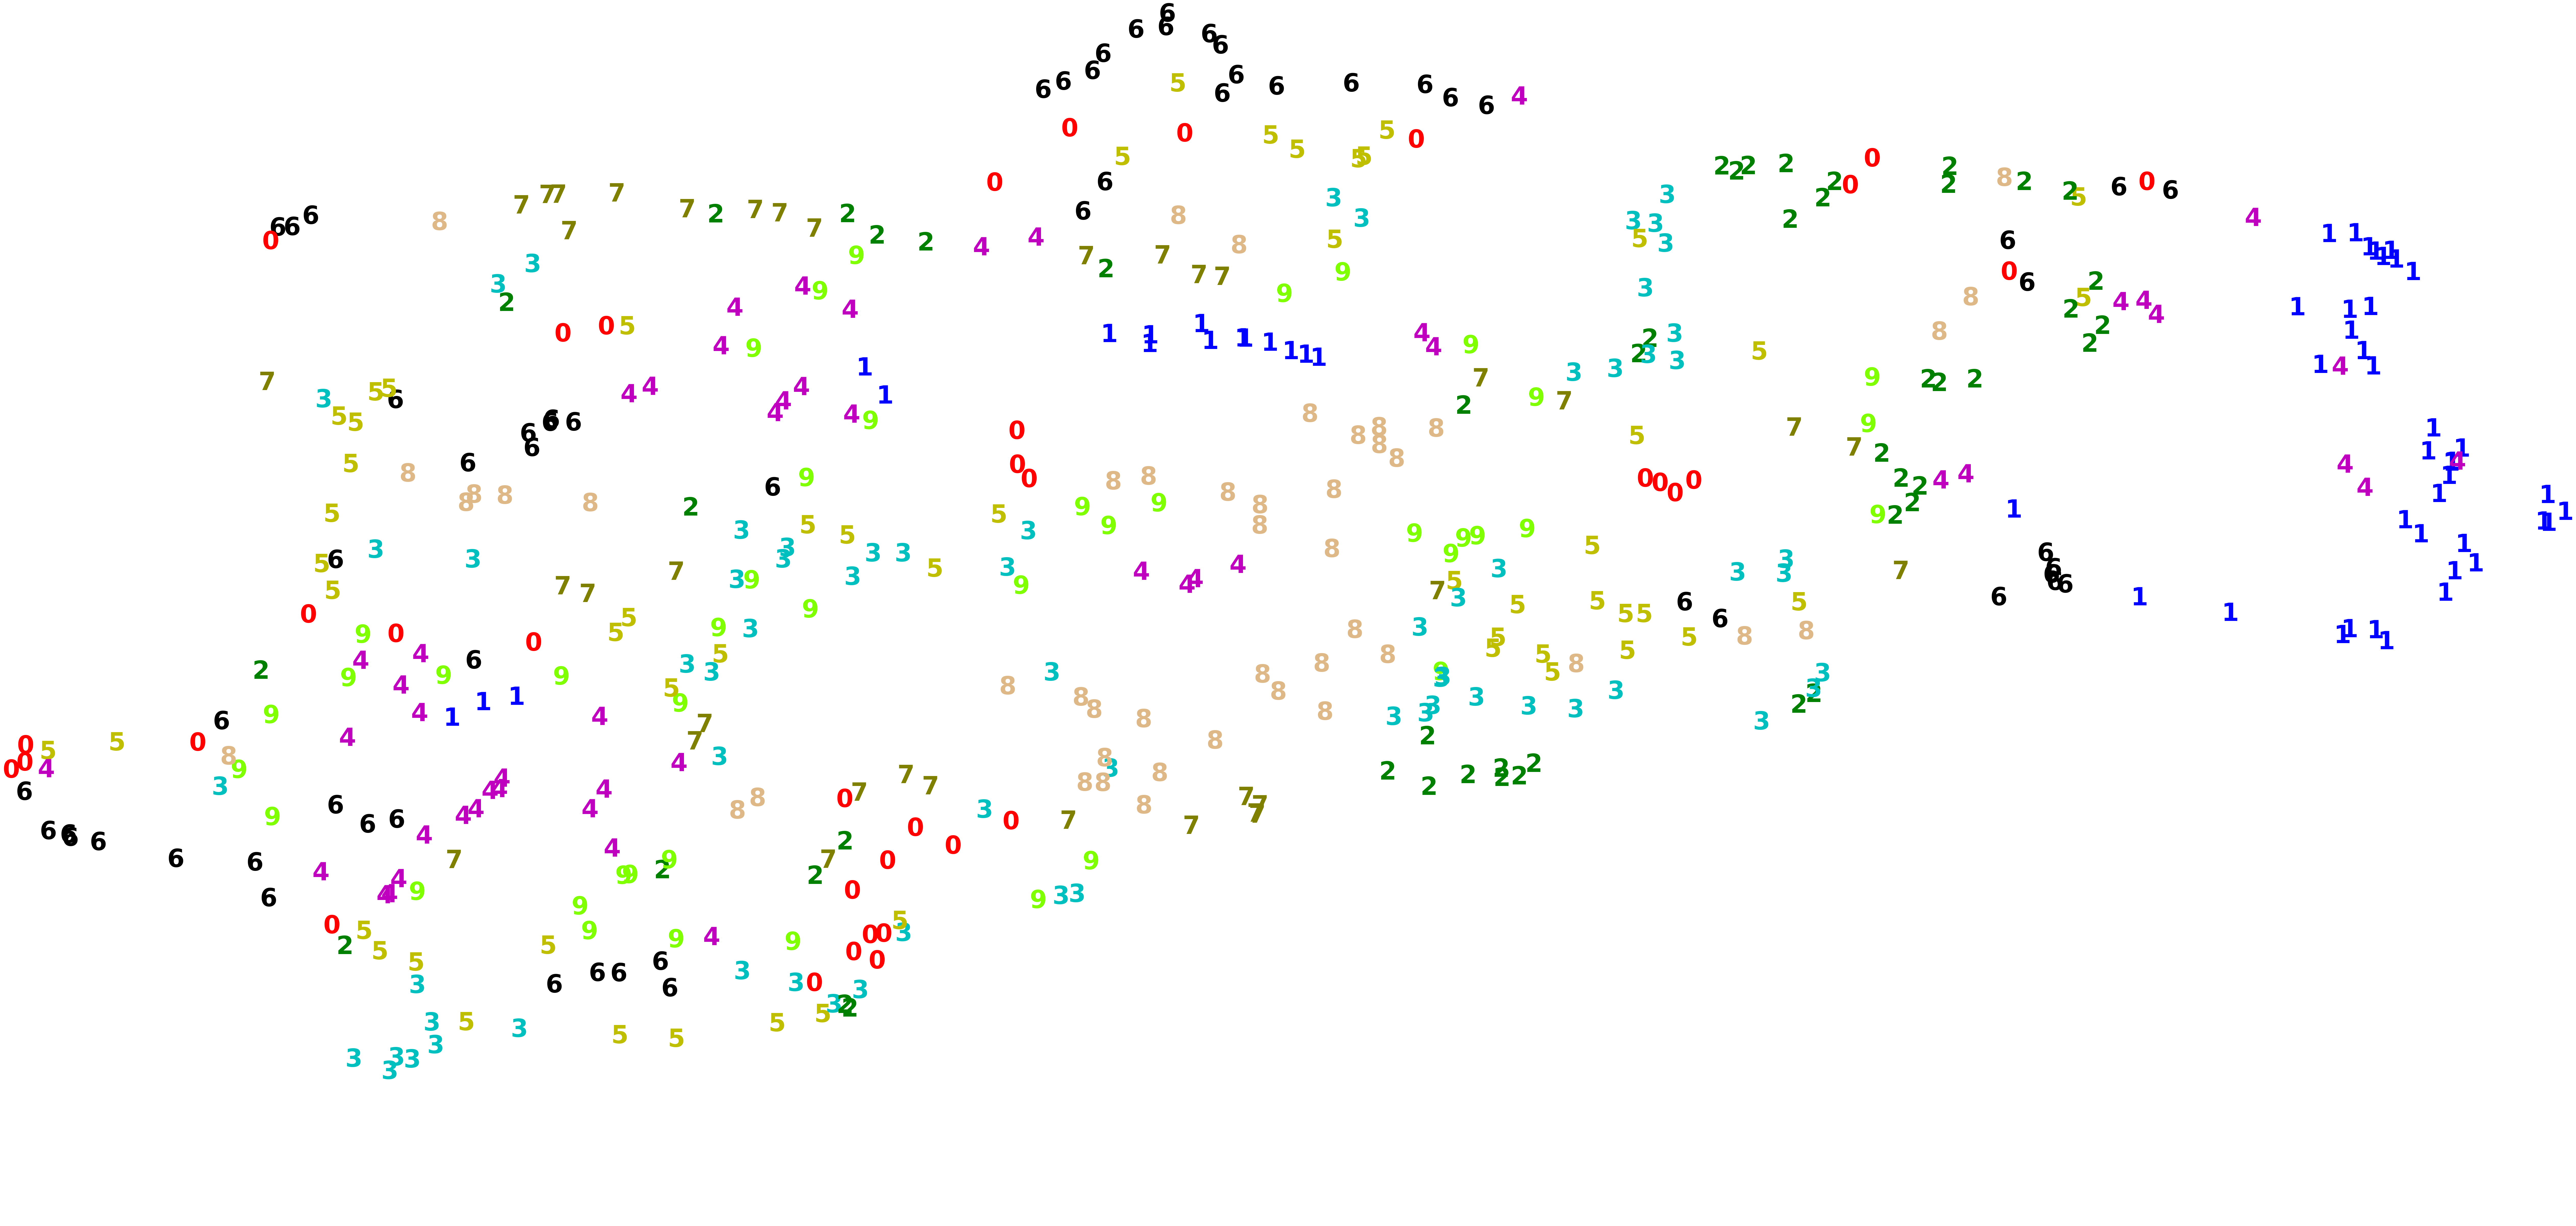

In [28]:
umap_tf_results = umap.UMAP(n_neighbors = 5,
                        min_dist = 0.3,
                        metric = 'correlation').fit_transform(X_tf_test[:500])

plt.figure(figsize=(10,5))
colours = ["r","b","g","c","m","y","k","olive","burlywood","chartreuse"]
for i in range(umap_tf_results.shape[0]):
    plt.text(umap_tf_results[i, 0], umap_tf_results[i, 1], predictions[i],
             color=colours[predictions[i]],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

The only difference between the following model and the previous one is the optimizer. In this model we will use `SGD`, but as I mentioned earlier we have to set the `learning rate` ourselves.

In [50]:
## model 2

tf.random.set_seed(42)

model_tf2 = Sequential()
model_tf2.add(Dense(784, input_shape=(3136,), activation='relu'))
model_tf2.add(Dense(128, activation='relu'))
model_tf2.add(Dense(64, activation='relu'))
model_tf2.add(Dense(10, activation='softmax'))
model_tf2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 784)            │     2,459,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,568,794 (9.80 MB)

 Trainable params: 2,568,794 (9.80 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
## training with batch_size = 512 
## SGD optimizer works on learning rates lower than the default.

model_tf2.compile(loss=losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), # low learning_rate
                metrics=['accuracy'])

time_start = time.time()
model_tf2.fit(X_tf_train, y_tf_train,
             batch_size=512,
             epochs = 10,
             verbose =1)

print('-'*50)
score_2 = model_tf2.evaluate(X_tf_test, y_tf_test, verbose=0)
print('Test score:', score_2[0])
print('Test accuracy:', score_2[1])

print('_'*20)
print('Time Elapsed: {}'.format(time.time() - time_start))

Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4740 - loss: 5.9643 
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8716 - loss: 0.4374
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9403 - loss: 0.2002
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9670 - loss: 0.1156
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9798 - loss: 0.0749
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9866 - loss: 0.0524
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9913 - loss: 0.0387
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9939 - loss: 0.0296
Epoch 9/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9957 - loss: 0.0233
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9969 - loss: 0.0189
--------------------------------------------------
Test score: 0.047796934843063354
Test accuracy: 0.9860286116600037
__________

In [46]:
model_tf2.optimizer.learning_rate

<KerasVariable shape=(), dtype=float32, path=adam/learning_rate>

---

Both PyTorch and TensorFlow have their own advantages, but considering the time of processing, it seems the TensorFlow models will converge in a significantly shorter amount of time.